<div class="alert alert-success"> 
        <h1 align="center" style="color:chocolate;">KANs for Task Incremental Learning
</h1>  
     
</div>

<div style="border-radius:10px; color:#000000; border:#DEB887 solid; padding: 15px; background-color: white; font-size:100%; text-align:left">

<h3 align="center"><font color='#DAA520'>Overview</font></h3>
    
- Implementing a Kolmogorov-Arnold Network (KAN) for Task Incremental Learning.
- Comparing KAN against a neural network of similar architecture.
- Utilizing the MNIST dataset to define tasks.
- Each task is a binary classification between two digits

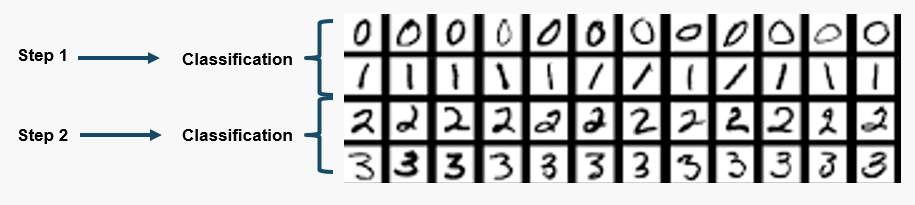

# Import Packages


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import datasets, transforms

device = 'cuda'

## Loading the Dataset

In [10]:
# Prepare the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Function to create binary classification tasks
def get_task_dataset(dataset, digit1, digit2):
    # Select indices for the two digits
    indices = [i for i, (x, y) in enumerate(dataset) if y == digit1 or y == digit2]
    task_dataset = Subset(dataset, indices)
    return task_dataset

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 10.7MB/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 473kB/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.90MB/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.26MB/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



## Define a simple neural network

In [4]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)  # Output layer for binary classification

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the input
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # Sigmoid for binary classification
        return x

# Define training function
def train(model, dataloader, criterion, optimizer, epochs=3):
    model.train()
    for epoch in range(epochs):
        for images, labels in dataloader:
            # Convert labels to binary (e.g., digit1=0, digit2=1)
            labels = (labels == digit2).float().view(-1, 1)  # Set digit2 as label 1
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Define testing function
def test(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            labels = (labels == digit2).float().view(-1, 1)  # Set digit2 as label 1
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = (outputs > 0.5).float()  # Classify as 0 or 1 based on threshold
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

# Set device, criterion, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Define tasks and train separately on each task

In [5]:
tasks = [(0, 1), (2, 3), (4, 5), (6, 7), (8, 9)]
for task_num, (digit1, digit2) in enumerate(tasks, 1):
    print(f"\nTraining on Task {task_num}: {digit1} vs {digit2}")
    task_dataset = get_task_dataset(mnist_dataset, digit1, digit2)
    dataloader = DataLoader(task_dataset, batch_size=64, shuffle=True)
    
    # Train and test on the current task
    train(model, dataloader, criterion, optimizer)
    test(model, dataloader)


Training on Task 1: 0 vs 1
Epoch [1/3], Loss: 0.0037
Epoch [2/3], Loss: 0.0000
Epoch [3/3], Loss: 0.0016
Test Accuracy: 100.00%

Training on Task 2: 2 vs 3
Epoch [1/3], Loss: 0.0979
Epoch [2/3], Loss: 0.1979
Epoch [3/3], Loss: 0.1419
Test Accuracy: 97.94%

Training on Task 3: 4 vs 5
Epoch [1/3], Loss: 0.2049
Epoch [2/3], Loss: 0.0769
Epoch [3/3], Loss: 0.0029
Test Accuracy: 98.93%

Training on Task 4: 6 vs 7
Epoch [1/3], Loss: 0.0008
Epoch [2/3], Loss: 0.0012
Epoch [3/3], Loss: 0.0083
Test Accuracy: 99.30%

Training on Task 5: 8 vs 9
Epoch [1/3], Loss: 0.0957
Epoch [2/3], Loss: 0.1815
Epoch [3/3], Loss: 0.0856
Test Accuracy: 97.73%


## Test Model after training

In [6]:
for task_num, (digit1, digit2) in enumerate(tasks, 1):
    print(f"\nTraining on Task {task_num}: {digit1} vs {digit2}")
    task_dataset = get_task_dataset(mnist_dataset, digit1, digit2)
    dataloader = DataLoader(task_dataset, batch_size=64, shuffle=True)
    test(model, dataloader)


Training on Task 1: 0 vs 1
Test Accuracy: 37.92%

Training on Task 2: 2 vs 3
Test Accuracy: 48.29%

Training on Task 3: 4 vs 5
Test Accuracy: 8.43%

Training on Task 4: 6 vs 7
Test Accuracy: 82.68%

Training on Task 5: 8 vs 9
Test Accuracy: 97.73%


## KAN

## Loading the Dataset

In [11]:
# Prepare the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=False)

# Function to create binary classification tasks and return data as dictionary
def get_task_dataset(dataset, digit1, digit2, train_ratio=0.8):
    # Select indices for the two digits
    indices = [i for i, (x, y) in enumerate(dataset) if y == digit1 or y == digit2]
    
    # Create subset of dataset with just the selected digits
    task_dataset = Subset(dataset, indices)
    
    # Split into training and testing based on train_ratio
    train_size = int(train_ratio * len(task_dataset))
    test_size = len(task_dataset) - train_size
    train_subset, test_subset = random_split(task_dataset, [train_size, test_size])
    
    # Extract inputs and labels for training and testing
    train_x = torch.stack([train_subset[i][0] for i in range(len(train_subset))])
    train_y = torch.tensor([train_subset[i][1] for i in range(len(train_subset))])
    test_x = torch.stack([test_subset[i][0] for i in range(len(test_subset))])
    test_y = torch.tensor([test_subset[i][1] for i in range(len(test_subset))])
    
    # Organize data into the specified dictionary format
    dataset_dict = {
        'train_input': train_x.to(device),
        'train_label': train_y.to(device),
        'test_input': test_x.to(device),
        'test_label': test_y.to(device)
    }
    
    return dataset_dict

# Example usage for Task 1 (0 vs 1)
device = 'cpu'
task_data = get_task_dataset(mnist_dataset, digit1=0, digit2=1)
print(task_data['train_input'][0])

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

## Creating and Training the KAN

In [12]:
from kan import KAN

model = KAN(width=[784, 2], grid=50, k=3, seed=0, device=device, noise_scale=0.1, sp_trainable=False, sb_trainable=False, base_fun='zero')

checkpoint directory created: ./model
saving model version 0.0


In [13]:
def train_acc():
    return torch.mean((torch.argmax(model(task_dataset['train_input']), dim=1) == task_dataset['train_label']).float())

def test_acc():
    return torch.mean((torch.argmax(model(task_dataset['test_input']), dim=1) == task_dataset['test_label']).float())

In [14]:
N=5

for task_num, (digit1, digit2) in enumerate(tasks, 1):
    print(f"\nTraining on Task {task_num}: {digit1} vs {digit2}")
    task_dataset = get_task_dataset(mnist_dataset, digit1, digit2)
    task_dataset['train_input'] = task_dataset['train_input'].squeeze().reshape((-1,784))
    task_dataset['test_input'] = task_dataset['test_input'].squeeze().reshape((-1,784))
    labels = task_dataset['train_label']
    labels = torch.where(labels == digit1, torch.tensor(0), labels)
    labels = torch.where(labels == digit2, torch.tensor(1), labels)
    task_dataset['train_label'] = labels

    labels = task_dataset['test_label']
    labels = torch.where(labels == digit1, torch.tensor(0), labels)
    labels = torch.where(labels == digit2, torch.tensor(1), labels)
    task_dataset['test_label'] = labels

    dataloader = DataLoader(task_dataset, batch_size=64, shuffle=True)
    results = model.fit(task_dataset, 
                        opt="LBFGS",
                        metrics=(train_acc, test_acc),
                        loss_fn=torch.nn.CrossEntropyLoss(),
                        steps=N, update_grid=False)
    print('Training Accuracy :', results['train_acc'][-1])
    print('Test Accuracy :', results['test_acc'][-1])



Training on Task 1: 0 vs 1


| train_loss: 0.00e+00 | test_loss: 1.12e-01 | reg: 1.31e+02 | : 100%|█| 5/5 [01:32<00:00, 18.41s/it


saving model version 0.1
Training Accuracy : 1.0
Test Accuracy : 0.9976359605789185

Training on Task 2: 2 vs 3


| train_loss: 0.00e+00 | test_loss: 7.55e-01 | reg: 4.91e+02 | : 100%|█| 5/5 [01:45<00:00, 21.15s/it


saving model version 0.2
Training Accuracy : 1.0
Test Accuracy : 0.9657701849937439

Training on Task 3: 4 vs 5


| train_loss: 1.99e-05 | test_loss: 3.49e-01 | reg: 5.55e+02 | : 100%|█| 5/5 [01:38<00:00, 19.67s/it


saving model version 0.3
Training Accuracy : 1.0
Test Accuracy : 0.9866666793823242

Training on Task 4: 6 vs 7


| train_loss: 0.00e+00 | test_loss: 2.68e-01 | reg: 7.84e+02 | : 100%|█| 5/5 [01:27<00:00, 17.43s/it


saving model version 0.4
Training Accuracy : 1.0
Test Accuracy : 0.9949748516082764

Training on Task 5: 8 vs 9


| train_loss: 1.73e-05 | test_loss: 5.46e-01 | reg: 8.30e+02 | : 100%|█| 5/5 [01:37<00:00, 19.52s/it

saving model version 0.5
Training Accuracy : 1.0
Test Accuracy : 0.982367753982544


## Test Model after training

In [15]:
for task_num, (digit1, digit2) in enumerate(tasks, 1):
    print(f"\nTraining on Task {task_num}: {digit1} vs {digit2}")
    task_dataset = get_task_dataset(mnist_dataset, digit1, digit2)
    task_dataset['train_input'] = task_dataset['train_input'].squeeze().reshape((-1,784))
    task_dataset['test_input'] = task_dataset['test_input'].squeeze().reshape((-1,784))
    labels = task_dataset['train_label']
    labels = torch.where(labels == digit1, torch.tensor(0), labels)
    labels = torch.where(labels == digit2, torch.tensor(1), labels)
    task_dataset['train_label'] = labels

    labels = task_dataset['test_label']
    labels = torch.where(labels == digit1, torch.tensor(0), labels)
    labels = torch.where(labels == digit2, torch.tensor(1), labels)
    task_dataset['test_label'] = labels

    print('Training Accuracy :', train_acc())
    print('Test Accuracy :', test_acc())


Training on Task 1: 0 vs 1
Training Accuracy : tensor(0.4427)
Test Accuracy : tensor(0.3924)

Training on Task 2: 2 vs 3
Training Accuracy : tensor(0.6595)
Test Accuracy : tensor(0.6504)

Training on Task 3: 4 vs 5
Training Accuracy : tensor(0.2168)
Test Accuracy : tensor(0.2347)

Training on Task 4: 6 vs 7
Training Accuracy : tensor(0.9112)
Test Accuracy : tensor(0.9146)

Training on Task 5: 8 vs 9
Training Accuracy : tensor(0.9962)
Test Accuracy : tensor(0.9975)


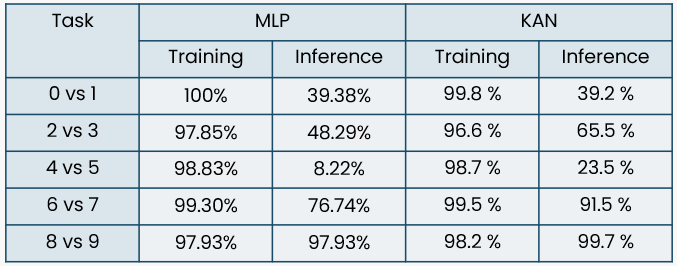

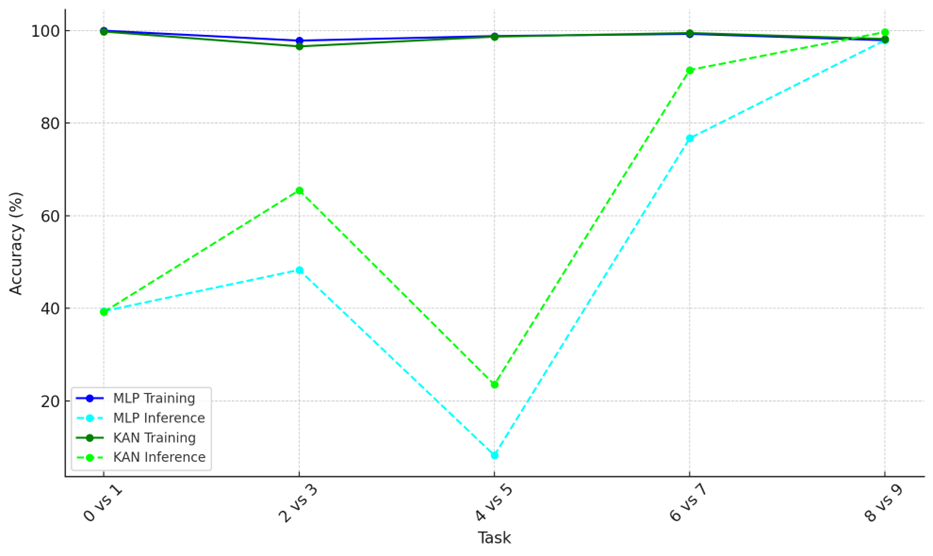

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: green; font-size:100%; text-align:left">

<h3 align="center"><font color='white'>💡 Summary from above :</font></h3>

The KAN and MLP models demonstrate limited accuracy in the context of task incremental learning.